# Variational Quantum Metrology

<em> Copyright (c) 2022 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## Background

Quantum metrology is the study of high resolution and high sensitivity measurements of physical parameters using quantum theory (e.g., quantum entanglement) in order to further describe physical systems. Its theoretical aspect is quantum parameter estimation theory, and its experimental aspect is called quantum sensing. Previous studies have shown that the estimation accuracy by quantum theory is improved by taking the square root of the required number of samples compared with the classical method [1-3]. For an unknown parameter, the goal of quantum metrology is to maximize the accuracy of parameter estimation while minimizing the required resources (such as time, number of qubits, etc.).

For example, given a unitary $e^{-i\phi H}$ with a known Hamiltonian $H$, how can we extract the information about $\phi$ by quantum metrology? It comprises the following four steps:

1. Preparation. Prepare an input state $|\psi\rangle$.
2. Parameterization. Obtain the parameterized quantum state $e^{-i\phi H}|\psi\rangle$ after the evolution of $e^{-i\phi H}$.
3. Measurement. Measure the output state.
4. Classical estimation. Estimate the parameters based on the results of multiple measurements.

Combined with quantum parameter estimation theory, this tutorial is based on the idea of variational quantum sensors in [4], and the parameterized quantum circuit is constructed using Paddle Quantum to train the loss function and obtain a quantum sensor that can estimate the parameters that are normally distributed.

## Parameter Estimation Theory

### Classical  parameter estimation

Classical parameter estimation, such as the maximum-likelihood estimator (MLE), uses multiple samples to calculate data containing an unknown parameter. That is, given a probability distribution depending on an unknown parameter $\phi$, where $f$ is the probability density function, and ${\bf{X}}=\{X_1,X_2,... X_N\}$ is $N$ independent and identically distributed sample data, the estimated value $\hat\phi$ is obtained by using MLE:

$$
\hat\phi({\bf X})=\arg\max_{\phi}\prod_i^Nf(X_i,\phi), \tag{1}
$$

which finds $\phi$ such that $X_i(i=1,...,N)$ occurs with maximum probability. After obtaining the estimated parameters, how to measure the difference between the estimated parameters and the actual parameters? That is, how to measure the accuracy of the estimated parameters? In the parameter estimation theory, mean squared error (MSE) is generally used to measure the accuracy.

The sample containing the unknown parameter $\bf{\phi}$ is ${\bf{X}}=\{X_1,X_2,... X_N\}\in {\mathcal F}^N$, where ${\mathcal F}^N$ is the sample space. Let $\hat{\phi}({\bf X}):{\mathcal F}^N\rightarrow\Phi$ be the estimator that estimates $\phi\in\Phi$ ($\Phi$ is the parameter space). Then the MSE of $\hat{\phi}(\bf X)$ with respect to $\phi$ is defined as

$$
\begin{aligned}
{\rm{MSE}}&=
E[(\hat{\phi}({\bf X})-\phi)^2]\\
&=\sum_{{\bf X}\in {\mathcal F}^N}f({\bf X};\phi)(\hat{\phi}({\bf X)}-\phi)^2,
\end{aligned} \tag{2}
$$

where $f({\bf X}; \phi)$ is the probability density of getting the current sample $\bf X$ given the parameter $\phi$. Although different estimators affect the value of MSE, regardless of the choice of $\hat{\phi}({\bf X})$, there is ${\rm{MSE}}\geq\frac{1}{N{\mathcal I(\phi)}}$. This lower bound is known as the Cramér–Rao (CR) bound [2], where $\mathcal I(\phi)$ is the Fisher information, which reflects to what extent a slight parameter change will change the probability distribution (see [Quantum Fisher Information](https://qml.baidu.com/tutorials/qnn-research/quantum-fisher-information.html) for the application of Fisher information in Paddle Quantum). 

### Quantum parameter estimation

In quantum parameter estimation, the samples used in classical parameter estimation become a quantum state $\rho_{\phi}\in{\mathcal F}({\mathcal H})$ to be measured, where $\phi$ is the unknown parameter and ${\mathcal F}({\mathcal H})$ denotes the set of density operators on the Hilbert space $\mathcal H$. According to the steps of quantum metrology and [4], assuming that the initial input state is $|0\rangle$ and the estimator is $\hat{\phi}(m)$, where $m$ is related to the measured results (such as the difference in the number of 1s and the number of 0s in the measured bit string), then the MSE is

$$
\begin{aligned}
{\rm MSE}&=E[(\hat{\phi}(m)-\phi)^2]\\
&=\sum_m(\hat{\phi}(m)-\phi)^2p(m|\phi),
\end{aligned} \tag{3}
$$

where $p(m|\phi)$ is the probability of obtaining $m$ by measurement with a given parameter $\phi$. Similarly, no matter how $\hat{\phi}(m)$ is chosen, there is a quantum CR bound ${\rm{MSE}}\geq\frac{1}{NF(\phi)}$, where $N$ is the number of repeated measurements of $\rho_\phi$, and $F(\phi)$ is the quantum Fisher information (see [Quantum Fisher Information](https://qml.baidu.com/tutorials/qnn-research/quantum-fisher-information.html) for the application of quantum Fisher information in Paddle Quantum). 

## Variational Quantum Sensors

Quantum sensing is the application of quantum metrology. Based on [4], this tutorial mainly introduces a kind of variational Ramsey interferometer. The traditional Ramsey interferometer [2] (as shown in Figure 1) is a particle interferometry method that uses magnetic resonance phenomena to measure particle transition frequency and is used to measure unknown parameters. The variational Ramsay interferometer [6] (as shown in Figure 2) consists of two parameterized quantum circuits (denoted as $U_{\rm{En}}(\theta_{\rm En})$ and $U_{\rm{De}}(\theta_{\rm{De}})$) in the encoding and decoding parts of the circuit for setting entanglement and measuring quantum states. Previous studies have shown that by combining with quantum theory (such as quantum entanglement), the scaling of parameter estimation accuracy is enhanced to $\frac{1}{N}$ from $\frac{1}{\sqrt{N}}$ [1-3], and the appropriate entanglement mode can be effectively found by the variational method.

![Ramsey_interferomertry](./figures/QM-fig-RI.png "Figure 1：Ramsey interferometer.")
<center> Figure 1：Ramsey interferometer. On the left is the classical configuration of a Ramsey interferometer, and on the right is a Ramsey interferometer using quantum entanglement. Compared with the classical setting, the interferometer using quantum entanglement has an advantage in the order of square root in the accuracy of estimating unknown parameters. </center>

![V_Ramsey_interferomertry](./figures/QM-fig-V_RI3.png "Figure 2：Variational Ramsey interferometer.")
<center> Figure 2：Variational Ramsey interferometer. Two parameterized quantum circuits are optimized to find an efficient way of utilizing entanglement. </center>

In the following, we construct a parameterized quantum circuit using Paddle Quantum to investigate the accuracy of estimating normally distributed parameters by a variational Ramsey interferometer. There are three steps as follows.
1. Initialization.
2. Evaluation.
3. Optimization.

The probability density function of the parameters that obey the normal distribution is:

$$
f(x)=\frac{1}{\sqrt{2\pi}\nu}\exp(-\frac{(x-\mu)^2}{2\nu^2}), \tag{4}
$$

where $\mu$ is the mean and $\nu^2$ is the variance. In this case, the loss function of the variational Ramsey interferometer is:

$$
C(\theta_{\rm En},\theta_{\rm De},a)=\int d\phi f(\phi){\rm{MSE}}(\phi), \tag{5}
$$

where the estimator is $\hat\phi(m)=am$, $a$ is a parameter to be optimized, $m$ is the difference in the number of 1s and the number of 0s in the measured bit string, ${\rm MSE(\phi)}=\sum_m(\hat{\phi}(m)-\phi)^2p_{\theta}(m|\phi)$, and $\theta=(\theta_{\rm En},\theta_{\rm De})$.

### 1. Initializaiton

- Set the input state as $|0\rangle$.
- Construct the parameterized quantum circuits $U_{\rm{En}}$ and $U_{\rm{De}}$ for encoding and decoding, respectively.
- Encode the unknown parameter.

Let us import the necessary packages:

In [1]:
import numpy as np
from math import exp, pi
import matplotlib.pyplot as plt
from typing import Optional, Tuple, List

import paddle
import paddle_quantum as pq
from paddle_quantum.ansatz import Circuit
from paddle_quantum.loss import Measure

pq.set_backend('state_vector')
pq.set_dtype('complex128')

Next, we construct a parameterized quantum circuit of $N$ qubits to complete the initialization.

The whole circuit includes the following five parts.
- $R_y^{\otimes N}(\frac{\pi}{2})$ gates.
- Encoding circuit $U_{\rm{En}}(\theta_{\rm{En}})$.
- Circuit with unknown parameter $R_z^{\otimes N}(\phi)=e^{-i\phi J_z}$, where $J_z=\frac{1}{2}\sum_{k=1}^N\sigma_z^{(k)}$.
- Decoding circuit $U_{\rm{De}}(\theta_{\rm{De}})$.
- $R_x^{\otimes N}(\frac{\pi}{2})$ gate.

So the unitary of the entire circuit is

$$
U(\phi,\theta_{\rm{En}},\theta_{\rm{De}})=R_x^{\otimes N}(\frac{\pi}{2})U_{\rm{De}}(\theta_{\rm{De}})R_z^{\otimes N}(\phi)U_{\rm{En}}(\theta_{\rm{En}})R_y^{\otimes N}(\frac{\pi}{2}). \tag{6}
$$

When the depth of the encoding circuit and decoding circuit is $0$, the entire circuit is the classical configuration of a Ramsey interferometer. Here we construct the encoding and the decoding circuits.

In [2]:
def RamseyCircuit(theta_EN: paddle.Tensor, theta_DE: paddle.Tensor, input_phi: float) -> Circuit:
    r""" Construct variational Ramsey interferometer
    
    Args:
        theta_EN: the parameters of encoding circuit, shape is [depth_En, num_qubits，3]
        theta_DE: the parameters of decoding circui, shape is [depth_De, num_qubits，3]
        input_phi: unknown parameter
    
    Returns:
        Circuit
    
    """
    depth_EN, depth_DE = theta_EN.shape[0], theta_DE.shape[0]
    num_qubits = theta_EN.shape[1]
    
    cir = Circuit(num_qubits)
    cir.ry(param=pi/2)
    
    # Construct the encoding circuit to generate an entangled state
    for depth in range(depth_EN):
        cir.u3(param=theta_EN[depth])
        cir.cnot()
    
    # the gate of unknown parameter
    cir.rz(param=input_phi)
    
    # Construct the decoding circuit to rotate the measurement basis
    for depth in range(depth_DE):
        cir.cnot()
        cir.u3(param=theta_DE[depth])
        
    cir.rx(param=pi/2)
    
    return cir

### 2. Evaluation

- Calculate the probability distribution of $m$.
- Calculate the MSE of the estimator $\hat{\phi}(m)=am$: ${\rm MSE}=\sum_m(\hat{\phi}(m)-\phi)^2p_{\theta}(m|\phi)$.
- Calculate the loss function. Here, we use the discrete form of the loss function to approximate its integral form:

$$
C=\sum_{k=1}^t\frac{2}{t}f(\phi_k){\rm {MSE}}, \tag{7}
$$

where $t$ is the number of partitions in the selected interval (the total interval size is $2$ in this tutorial), and $f(\phi_k)$ is the probability corresponding to $\phi_k$.

In [3]:
# Define the function to calculate m
def calculate_m(num_qubits: int)-> List[int]:
    m_list = []
    for k in range(2**num_qubits):
        k_bin = list(bin(k)[2:].zfill(num_qubits))
        u = k_bin.count('1')
        v = k_bin.count('0')
        m = u - v
        m_list.append(m)

    return m_list


def MSE(qnn: paddle.nn.Layer, phi: float) -> paddle.Tensor:
    r""" Calculate MSE 
    
    Args:
        cir: variational Ramsey interferometer
        phi: unknown parameter
        a: parameter of the estimator
        
    Returns:
        MSE
    
    """
    cir = RamseyCircuit(qnn.theta_EN, qnn.theta_DE, phi)
    
    # Measurement
    output_state = cir()
    prob = Measure()(output_state)
    
    num_qubits = cir.num_qubits
    m = calculate_m(num_qubits)
    return sum([((phi - qnn.a * m[i]) ** 2) * prob[i] for i in range(2 ** num_qubits)])

# Define loss function
def loss_func(qnn: paddle.nn.Layer, sampling_times: int, mean: float, variance: float):
    r""" Calculate loss 
    
    Args:
        qnn: a QNN
        sampling_times: the number of partitions in the selected interval
        mean: the mean of a normal distribution
        variance: the variance of a normal distribution
    
    """
    list_phi = [] # The list of phi
    list_pdf = [] # The list of the probability density function of phi
    for i in range(sampling_times):
        phi = mean - 1 + (2 * i + 1)/ sampling_times # The range of phi is [u - 1, u + 1]       
        prob = (1 / (((2 * pi) ** 0.5) * variance)) * exp(-((phi - mean) ** 2) / (2 * (variance**2)))  # The probability density of phi
        list_phi.append(phi)
        list_pdf.append(prob)
    
    return sum([list_pdf[i] * MSE(qnn, list_phi[i]) * (2 / sampling_times) for i in range(sampling_times)])

### 3. Optimization

In [4]:
def optimization(qnn: paddle.nn.Layer, num_itr: int, learning_rate: float) -> None:
    r""" Optimize QNN
    
    Args:
        qnn: a QNN
        num_itr: the number of optimization iterations
        learning_rate: learning rate
    
    """
    opt = paddle.optimizer.Adam(learning_rate=learning_rate, parameters=qnn.parameters())
    print("Begin：")
    for itr in range(1, num_itr):
        loss = qnn()
        loss.backward()
        opt.minimize(loss)
        opt.clear_grad()

        if itr % 10 == 0:
            print("     iter:", itr, "loss:", "%.4f" % loss.numpy())

In [9]:
class RamseyInterferometer(paddle.nn.Layer):
    r""" Variational Ramsey interferometer
    
    """
    def __init__(self) -> None:
        super().__init__()
        
        # Add parameters
        theta_EN = self.create_parameter(
            shape= [depth_EN, N, 3], dtype="float64",
            default_initializer=paddle.nn.initializer.Uniform(low=0, high=2 * pi),
        )
        theta_DE = self.create_parameter(
            shape= [depth_DE, N, 3], dtype="float64",
            default_initializer=paddle.nn.initializer.Uniform(low=0, high=2 * pi),
        )
        self.add_parameter('theta_EN', theta_EN)
        self.add_parameter('theta_DE', theta_DE)
        
        # Add the parameter of the estimator
        a = self.create_parameter(
            shape= [1], dtype="float64",
            default_initializer=paddle.nn.initializer.Uniform(low=0, high=2 * pi),
        )
        self.add_parameter('a', a)
        
    def forward(self) -> paddle.Tensor:
        r""" Calculate loss
        
        """
        return loss_func(self, TIMES, MEAN, VAR)
    
    def opt(self) -> None:
        r""" Optimize QNN
        
        """
        optimization(self, num_itr=ITR, learning_rate=LR)

In [ ]:
N = 2  # The number of qubits
depth_EN = 3  # The depth of encoding circuit
depth_DE = 3  # The depth of decoding circuit
LR = 0.2  # Learning rate
ITR = 150   # The number of optimization iterations
TIMES = 30  # The number of partitions in the selected interval
MEAN = 2  # The mean of a normal distribution
VAR = 1  # The variance of a normal distribution

In [14]:
QNN = RamseyInterferometer()
QNN.opt()

Begin：
     iter: 10 loss: 3.8495
     iter: 20 loss: 0.8521
     iter: 30 loss: 0.7484
     iter: 40 loss: 0.4504
     iter: 50 loss: 0.3610
     iter: 60 loss: 0.3375
     iter: 70 loss: 0.3042
     iter: 80 loss: 0.2827
     iter: 90 loss: 0.2600
     iter: 100 loss: 0.2386
     iter: 110 loss: 0.2217
     iter: 120 loss: 0.2096
     iter: 130 loss: 0.2026
     iter: 140 loss: 0.1996


The optimized circuit is used to estimate the parameters with a normal distribution, and then we draw the MSE.

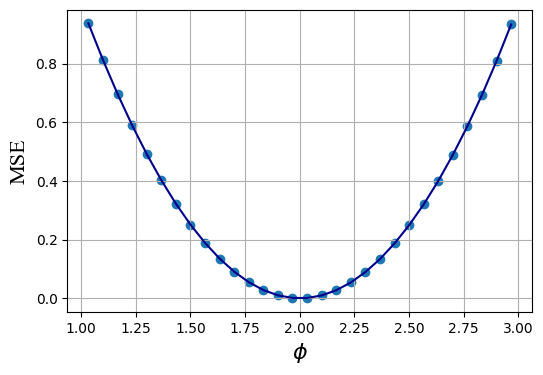

In [15]:
phi_list = []
mse_list = []
for i in range(TIMES):
    phi = MEAN - 1 + (2 * i + 1) / TIMES
    mse_est = MSE(QNN, phi)
    phi_list.append(phi)
    mse_list.append(mse_est)

font = {'family': 'Times New Roman', 'weight':'normal', 'size':16}
plt.figure(dpi=100)
plt.plot(phi_list,mse_list,color='darkblue', linestyle='-')
plt.scatter(phi_list,mse_list)
plt.xlabel('$\\phi$',font)
plt.ylabel('MSE',font)

plt.grid()
plt.show()

## Conclusion

We can see that the MSE estimated by the optimized quantum sensor is negatively correlated with the probability density of the parameters, and the value of MSE is the lowest near the mean value of the normal distribution, indicating that the obtained quantum sensor by variational method is effective for the parameters following a normal distribution.

---

## References

[1] Braunstein S L, Caves C M. Statistical distance and the geometry of quantum states[J]. [Physical Review Letters, 1994, 72(22): 3439](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.72.3439).

[2] Giovannetti V, Lloyd S, Maccone L. Quantum metrology[J]. [Physical review letters, 2006, 96(1): 010401](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.96.010401).

[3] Tóth G, Apellaniz I. Quantum metrology from a quantum information science perspective[J]. [Journal of Physics A: Mathematical and Theoretical, 2014, 47(42): 424006](https://iopscience.iop.org/article/10.1088/1751-8113/47/42/424006/meta).

[4] Marciniak C D, Feldker T, Pogorelov I, et al. Optimal metrology with programmable quantum sensors[J]. [Nature, 2022, 603(7902): 604-609](https://www.nature.com/articles/s41586-022-04435-4).

[5] Giovannetti V, Lloyd S, Maccone L. Advances in quantum metrology[J]. [Nature photonics, 2011, 5(4): 222-229](https://www.nature.com/articles/nphoton.2011.35).

[6] Kaubruegger R, Vasilyev D V, Schulte M, et al. Quantum variational optimization of Ramsey interferometry and atomic clocks[J]. [Physical Review X, 2021, 11(4): 041045](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.11.041045).